# Onchain User Page Rank

###  RPGF3 List ✨

In [1]:
from itertools import combinations
import json
import networkx as nx
import numpy as np
import pandas as pd

from scripts.oso_db import execute_query
from scripts.eas_lists import OsoData, listify, create_eas_json

# Prep

In [2]:
# settings

DATA_DIR  = "data/RPGF3/"
DATA_PATH = DATA_DIR + "2023-11_06_RPGF3_cleaned_applicant_data.json"

LIST_DESC = "This list applies the page rank algorithm to the graph of onchain users (powered by Open Source Observer)."
LINK_BASE = "https://github.com/opensource-observer/insights/blob/main/notebooks/"
FILENAME  = "2023-11-14_RPGF3_ContributorPageRank.ipynb"
LIST_LINK = LINK_BASE + FILENAME

LIST_EVAL = " ".join([
                "This is an experimental list format that uses the page rank algorithm to allocate",
                "20M OP tokens to onchain OSS projects that are represented on https://opensource.observer.",
                "First, it identifies onchain addresses with at least 30 transactions total, at least 10 days",
                "of activity, at least one transaction in the last 90 days, and interactions with at least 3",
                "protocols on OP Mainnet. Then, it creates a directed graph of users and runs page rank over the",
                "graph. Finally, it allocates tokens pro rata to projects based on page rank,",
                "rounded to the nearest 10K OP. If a contract address was not included as a link in a",
                "project's RPGF3 application, then it most likely won't be included here."
                "Note: lists generated by the OSO team do not include OSO in them in order to comply",
                "with voting rules, so please consider adding our project to your ballot separately. Always DYOR!"
                ]) 

LIST_CATS = [
            #'COLLECTIVE_GOVERNANCE',
            #'DEVELOPER_ECOSYSTEM', 
            'END_USER_EXPERIENCE_AND_ADOPTION', 
            #'OP_STACK'
            ]

AWARD_AMT = 2 * 10e6

JSON_PATH = DATA_DIR + "lists/OSO_OnchainPageRank.json"

In [3]:
# ingest data

oso = OsoData(DATA_PATH)
slugs = list(oso.get_project_slugs())
slugs_to_ids = oso.map_slugs_to_ids()

Loaded 311 OSS projects from data/RPGF3/2023-11_06_RPGF3_cleaned_applicant_data.json.
Identified 311 unique slugs.


# Get the data to power the list

In [4]:
# run query (may take a few minutes)

slugs_list = "','".join(slugs)

query = f"""
SELECT
    e."fromId",
    COUNT(DISTINCT p.slug) AS total_slugs,
    SUM(e."amount") AS total_txns,
    COUNT(DISTINCT e.time) AS total_days,
    MAX(e."time") AS last_txn
FROM
    event e
LEFT JOIN
    project_artifacts_artifact paa ON e."toId" = paa."artifactId"
LEFT JOIN
    project p ON paa."projectId" = p."id"
WHERE
    p.slug IN ('{slugs_list}')
    AND e."typeId" = 25
GROUP BY
    e."fromId";

"""
results = execute_query(query, col_names=True)

In [5]:
query = f"""
WITH ranked_events AS (
    SELECT
        e."fromId",
        p.slug AS slug,
        e.time,
        ROW_NUMBER() OVER (PARTITION BY e."fromId" ORDER BY e.time) AS rn
    FROM
        event e
    LEFT JOIN
        project_artifacts_artifact paa ON e."toId" = paa."artifactId"
    LEFT JOIN
        project p ON paa."projectId" = p."id"
    WHERE
        e."typeId" = 25
)
SELECT
    "fromId",
    slug AS first_interacted_slug
FROM
    ranked_events
WHERE
    rn = 1;
"""
first_slug = execute_query(query, col_names=True)

In [31]:
raw_df = pd.DataFrame(results[1:], columns=results[0])
raw_df['last_txn'] = raw_df['last_txn'].dt.strftime('%Y-%m-%d')

first_slug_df = pd.DataFrame(first_slug[1:], columns=first_slug[0]).set_index('fromId')
raw_df = raw_df.set_index('fromId').join(first_slug_df)
raw_df.head()

,total_slugs,total_txns,total_days,last_txn,first_interacted_slug
fromId,,,,,
81.0,1,5.0,1,2023-05-10,zora
240.0,1,1.0,1,2023-08-11,gitcoin
248.0,1,2.0,1,2023-10-12,ethereum-attestation-service
313.0,1,5.0,2,2023-11-10,gitcoin
529.0,1,639.0,43,2023-11-10,safe-global


In [32]:
# transform query results

df = raw_df.copy().dropna()

print(f"Feteched a total of {len(df)} addresses.")

tx_threshold = 30
df = df[df['total_txns']>=tx_threshold]
print(f"A total of {len(df)} passed the filter.")

active_days = 10
df = df[df['total_days']>=active_days]
print(f"A total of {len(df)} passed the filter.")

date_thresh = '2023-08-15'
df = df[df['last_txn'] >= date_thresh]
print(f"A total of {len(df)} passed the filter.")

project_thresh = 3
df = df[df['total_slugs']>=project_thresh]
print(f"A total of {len(df)} passed the filter.")

Feteched a total of 1432180 addresses.
A total of 104856 passed the filter.
A total of 82292 passed the filter.
A total of 57836 passed the filter.
A total of 48215 passed the filter.


In [35]:
df['first_interacted_slug'].value_counts().head(20)

first_interacted_slug
uniswap               7480
op                    5072
galxe                 4061
velodrome             2902
stargate-finance      2452
1-inch                2145
perpetual-protocol    1817
quix                  1678
lyra-finance          1505
shipyard-software     1385
slingshot             1334
rabbithole            1173
chain-hop             1059
across                1003
pika-protocol          986
pool-together          925
synapse                779
socket                 724
zeroex                 714
hop-protocol           650
Name: count, dtype: int64

In [48]:
df.groupby('first_interacted_slug')['total_slugs'].mean().sort_values().tail(20)

first_interacted_slug
rango-exchange       10.214286
shipyard-software    10.280144
chain-hop            10.320113
quix                 10.357569
connext              10.421569
mean-finance         10.444444
zerion               10.465438
orbiter-finance      10.466667
hop-protocol         10.723077
across               10.786640
olympus              11.000000
nested               11.101695
symphony-finance     11.118421
router-protocol      11.200000
sablier              11.368421
warden-swap          11.575758
x-dao                12.000000
hashflow             12.734982
unlock-protocol      13.142857
punk-domains         13.538462
Name: total_slugs, dtype: float64

In [15]:
nodes = list(slugs)
edges = []

for fromId, group in df.groupby('fromId'):
    project_set = group['slug'].tolist()
    project_set.sort(key=lambda x: group[group['slug'] == x]['first_txn'].values[0])
    
    for i in range(len(project_set) - 1):
        project1 = project_set[i]
        project2 = project_set[i + 1]
        contributions1 = group[group['slug'] == project1]['txns'].values[0]
        contributions2 = group[group['slug'] == project2]['txns'].values[0]
        harmonic_mean = 2 * contributions1 * contributions2 / (contributions1 + contributions2) if contributions1 + contributions2 > 0 else 0
        edges.append((project1, project2, harmonic_mean))

G = nx.DiGraph()
G.add_nodes_from(nodes)
G.add_weighted_edges_from(edges)
page_rank = nx.pagerank(G)
del page_rank['op']

page_rank = dict(sorted(page_rank.items(), key=lambda x: x[1], reverse=True)

pd.Series(page_rank).sort_values(ascending=False)

KeyboardInterrupt: 

# Generate the list

In [7]:
named_list = listify(page_rank, AWARD_AMT)
named_list = dict(sorted(named_list.items(), key=lambda x:x[0].lower()))
rpgf_list = {slugs_to_ids[k]:round(v/10000)*10000 for k,v in named_list.items()}

In [8]:
len(rpgf_list)

120

<AxesSubplot:>

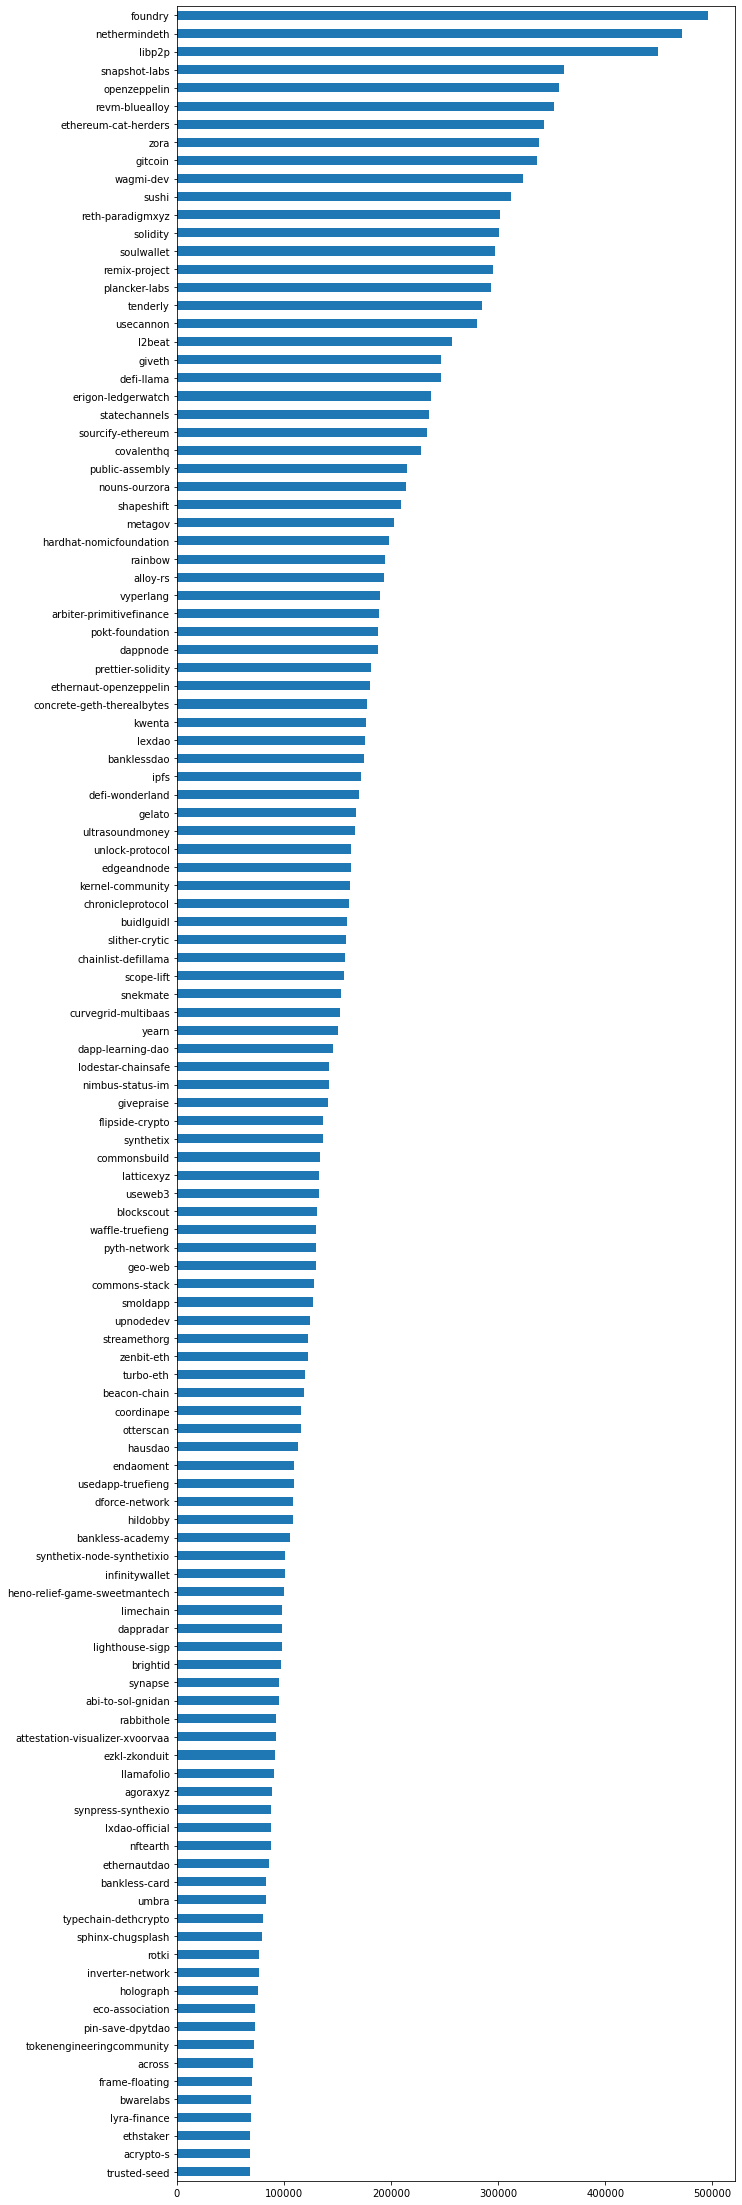

In [9]:
series = pd.Series(named_list).sort_values()
series = series[series>0]
series.plot(kind='barh', figsize=(10,len(rpgf_list)/3))

In [10]:
eas_metadata = create_eas_json(rpgf_list, LIST_DESC, LIST_LINK, LIST_EVAL, LIST_CATS)

In [11]:
with open(JSON_PATH, "w") as f:
    json.dump(eas_metadata, f, indent=4)